# DCGAN Parameters and Concepts Guide

## 1. Basic Network Architecture Parameters

### Latent Dimension
- Size: 100
- Purpose: Input size for the Generator
- Optimal Range: 100-200
- Impact: Larger values increase variety but make training more difficult

Gizli boyut Generator'ın giriş boyutudur. 100-200 arası optimum değerler verir. Büyük değerler çeşitliliği artırır ama eğitimi zorlaştırır.

### Batch Size
- Recommended Size: 64
- Optimal Range: 64-128
- Considerations: 
  - Larger batches stabilize training but increase memory usage
  - Avoid sizes < 32 or > 256

Parti boyutu önerilen değeri 64'tür. 64-128 arası optimal performans verir. Büyük parti boyutları eğitimi stabilize eder ama bellek kullanımını artırır. 32'den küçük veya 256'dan büyük değerlerden kaçınılmalıdır.

## 2. Optimization Parameters

### Learning Rates
- Generator: 0.0002
- Discriminator: 0.0001
- Adam Optimizer Settings:
  - Beta1: 0.5
  - Beta2: 0.999

Öğrenme oranları - Generator için 0.0002, Discriminator için 0.0001 kullanılır. Adam optimize edici için Beta1 0.5 ve Beta2 0.999 değerleri kullanılır.

## 3. Advanced Techniques

### Label Smoothing
- Real Labels: 0.9 (instead of 1.0)
- Fake Labels: 0.1 (instead of 0.0)
- Purpose: Prevents overconfidence in Discriminator

Etiket yumuşatma - Gerçek etiketler için 1.0 yerine 0.9, sahte etiketler için 0.0 yerine 0.1 kullanılır. Amaç, Discriminator'ın aşırı özgüvenini engellemektir.

### Gradient Clipping
- Max Norm: 1.0
- Purpose: Prevents exploding gradients
- Implementation: Applied to Discriminator parameters

Gradyan kırpma - Maksimum norm 1.0'dır. Gradyan patlamasını önler ve Discriminator parametrelerine uygulanır.

## 4. Network Architecture Details

### Generator Architecture
- Input: latent_dim x 1 x 1
- Layer Progression:
  - 512 x 4 x 4
  - 256 x 8 x 8
  - 128 x 16 x 16
  - 64 x 32 x 32
  - 1 x 64 x 64 (output)

Generator mimarisi belirtilen boyutlarda ilerleyen katmanlardan oluşur. Giriş boyutundan başlayarak çıkış boyutuna kadar kademeli olarak büyür.

### Discriminator Architecture
- Input: 1 x 64 x 64
- Layer Progression:
  - 64 x 32 x 32
  - 128 x 16 x 16
  - 256 x 8 x 8
  - 512 x 4 x 4
  - 1 (output)

Discriminator mimarisi giriş boyutundan başlayarak kademeli olarak küçülen katmanlardan oluşur ve tek bir çıkış değeri üretir.

## 5. Expected Results

### Loss Values
- Discriminator Loss: Should stabilize around 0.5
- Generator Loss: Should converge to lower values
- Training Balance: Important to maintain equilibrium between Generator and Discriminator

Kayıp değerleri - Discriminator kaybı 0.5 civarında dengelenmeli, Generator kaybı daha düşük değerlere yakınsamalıdır. Eğitimde Generator ve Discriminator arasındaki dengeyi korumak önemlidir.

##### Important note! : Due to the DC GAN architecture, the image size must be selected between 32 - 256. (DC GAN yapısından dolayı image size → 32 - 256 arasında seçilmelidir.)

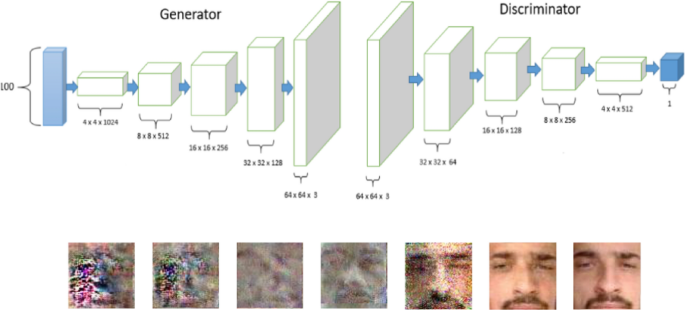

* DCGAN Training Process: The Generator takes random noise as input and transforms it through multiple layers to create synthetic data based on features learned from the training dataset. The architecture progresses from a small latent space to larger feature maps through transposed convolutions until reaching the target image size, with each layer refining and upscaling the features. (DCGAN Eğitim Süreci: Generator, rastgele gürültüyü girdi olarak alır ve eğitim veri setinden öğrenilen özelliklere dayanarak sentetik veri oluşturmak için çoklu katmanlar aracılığıyla dönüştürür. Mimari, küçük bir gizli uzaydan başlayarak, transpoze konvolüsyonlar aracılığıyla daha büyük özellik haritalarına doğru ilerler ve hedef görüntü boyutuna ulaşana kadar her katmanda özellikleri iyileştirir ve ölçeklendirir.)

#### Layer Architecture:
```bash
Input: Random noise (100x1x1)
             ↓
Layer 1: 512x4x4 (First upscaling)
             ↓
Layer 2: 256x8x8 (Feature expansion)
             ↓
Layer 3: 128x16x16 (Further refinement)
             ↓
Layer 4: 64x32x32 (Detail enhancement)
             ↓
Output: 1x64x64 (Final image)
```

# Grayscale Clothes DC-GAN Training

In [ ]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image, make_grid
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# [CustomDataset, Generator, ve Discriminator sınıfları aynı kalıyor...]

def train_dcgan(dataloader, num_epochs=100, latent_dim=100, device='cuda'):
    # Çıktı klasörlerini oluştur
    os.makedirs('/kaggle/working/generated_images', exist_ok=True)
    os.makedirs('/kaggle/working/loss_plots', exist_ok=True)
    os.makedirs('/kaggle/working/sample_grid', exist_ok=True)
    
    # Models
    generator = Generator(latent_dim).to(device)
    discriminator = Discriminator().to(device)
    
    # Optimizers
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
    
    # Schedulers
    g_scheduler = torch.optim.lr_scheduler.ExponentialLR(g_optimizer, gamma=0.99)
    d_scheduler = torch.optim.lr_scheduler.ExponentialLR(d_optimizer, gamma=0.99)
    
    criterion = nn.BCELoss()
    
    # Kayıp değerlerini takip etmek için listeler
    g_losses = []
    d_losses = []
    
    # Sabit noise vektörü (görsel karşılaştırma için)
    fixed_noise = torch.randn(50, latent_dim, 1, 1, device=device)
    
    for epoch in range(num_epochs):
        for i, real_images in enumerate(dataloader):
            batch_size = real_images.size(0)
            
            # Label smoothing
            real_label = torch.full((batch_size,), 0.9, device=device)
            fake_label = torch.full((batch_size,), 0.1, device=device)
            
            # Train Discriminator
            discriminator.zero_grad()
            real_images = real_images.to(device)
            real_images = real_images + torch.randn_like(real_images) * 0.05
            
            d_output_real = discriminator(real_images)
            d_loss_real = criterion(d_output_real, real_label)
            
            z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            fake_images = generator(z)
            d_output_fake = discriminator(fake_images.detach())
            d_loss_fake = criterion(d_output_fake, fake_label)
            
            d_loss = (d_loss_real + d_loss_fake) / 2
            d_loss.backward()
            
            torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)
            d_optimizer.step()
            
            # Train Generator
            if i % 2 == 0:
                generator.zero_grad()
                d_output_fake = discriminator(fake_images)
                g_loss = criterion(d_output_fake, real_label)
                g_loss.backward()
                
                torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
                g_optimizer.step()
            
            # Her epoch'ta 50 örnek görüntü oluştur ve kaydet
            if i == 0:  # Her epoch'un başında
                with torch.no_grad():
                    fake_samples = generator(fixed_noise)
                    save_image(fake_samples,
                             f'/kaggle/working/sample_grid/epoch_{epoch}.png',
                             nrow=10, normalize=True)
                    
                    # Ayrı ayrı görüntüleri kaydet
                    for idx, img in enumerate(fake_samples):
                        save_image(img, 
                                 f'/kaggle/working/generated_images/epoch_{epoch}_sample_{idx}.png',
                                 normalize=True)
            
            # Loss değerlerini kaydet
            if i % 50 == 0:
                print(f'Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(dataloader)}] '
                      f'D_loss: {d_loss.item():.4f} G_loss: {g_loss.item():.4f}')
                g_losses.append(g_loss.item())
                d_losses.append(d_loss.item())
        
        # Learning rate güncelle
        g_scheduler.step()
        d_scheduler.step()
        
        # Her epoch sonunda loss grafiğini çiz ve kaydet
        plt.figure(figsize=(10, 5))
        plt.plot(g_losses, label='Generator Loss', alpha=0.7)
        plt.plot(d_losses, label='Discriminator Loss', alpha=0.7)
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title(f'Training Losses (Epoch {epoch})')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig(f'/kaggle/working/loss_plots/loss_plot_epoch_{epoch}.png')
        plt.close()
    
    # Modelleri kaydet
    torch.save({
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'g_optimizer_state_dict': g_optimizer.state_dict(),
        'd_optimizer_state_dict': d_optimizer.state_dict(),
        'g_losses': g_losses,
        'd_losses': d_losses,
    }, '/kaggle/working/model_final.pth')

if __name__ == "__main__":
    batch_size = 64
    image_size = 64
    latent_dim = 100
    num_epochs = 200
    
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ])
    
    dataset = CustomDataset('/kaggle/input/fashion-mnist-png/train', transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2,
                          pin_memory=True, drop_last=True)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_dcgan(dataloader, num_epochs=num_epochs, latent_dim=latent_dim, device=device)

# Original Dataset Images

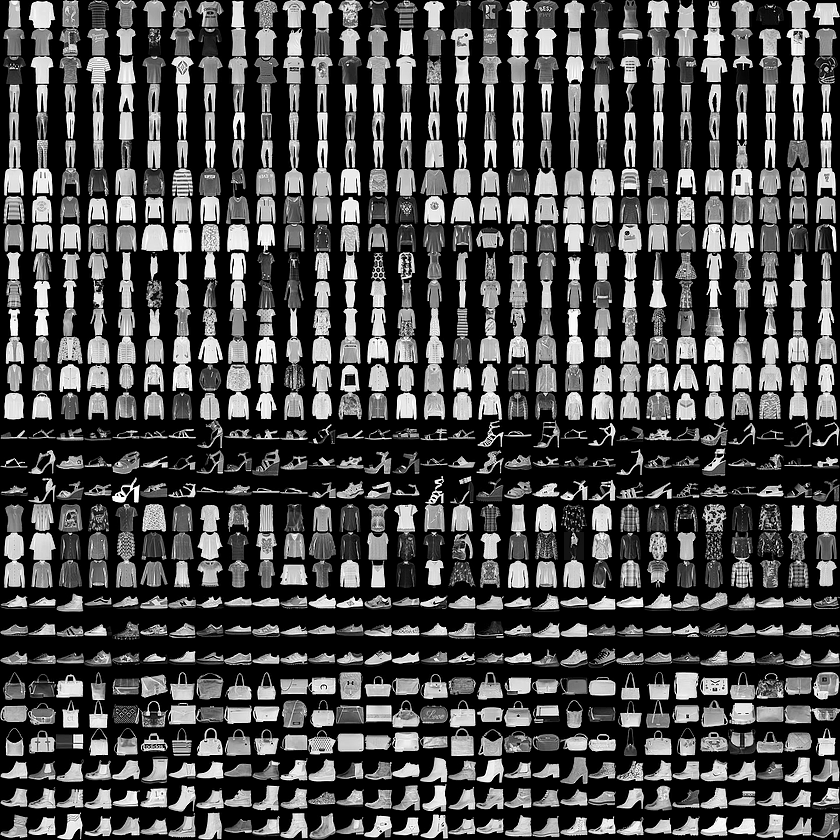

# RGB Food Training

In [ ]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt

# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.image_paths = []
        
        # Tüm alt dizinlerdeki görüntüleri toplar
        for class_dir in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_dir)
            if os.path.isdir(class_path):  # Sadece alt dizinleri kontrol eder
                self.image_paths.extend(
                    [os.path.join(class_path, fname) for fname in os.listdir(class_path) if fname.endswith(('png', 'jpg', 'jpeg'))]
                )

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  # RGB modunda açar
        if self.transform:
            image = self.transform(image)
        return image

# Generator Model
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 1024, 4, 1, 0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.main(z)

# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1024, 4, 2, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(1024, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1, 1).squeeze(1)

# Training Function
def train_dcgan(dataloader, num_epochs=100, latent_dim=100, device='cuda'):
    os.makedirs('/kaggle/working/generated_images', exist_ok=True)
    os.makedirs('/kaggle/working/loss_plots', exist_ok=True)
    os.makedirs('/kaggle/working/sample_grid', exist_ok=True)

    generator = Generator(latent_dim).to(device)
    discriminator = Discriminator().to(device)

    g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

    g_scheduler = torch.optim.lr_scheduler.ExponentialLR(g_optimizer, gamma=0.99)
    d_scheduler = torch.optim.lr_scheduler.ExponentialLR(d_optimizer, gamma=0.99)

    criterion = nn.BCELoss()
    g_losses, d_losses = [], []
    fixed_noise = torch.randn(50, latent_dim, 1, 1, device=device)

    for epoch in range(num_epochs):
        for i, real_images in enumerate(dataloader):
            batch_size = real_images.size(0)
            real_label = torch.full((batch_size,), 0.9, device=device)
            fake_label = torch.full((batch_size,), 0.1, device=device)

            discriminator.zero_grad()
            real_images = real_images.to(device) + torch.randn_like(real_images).to(device) * 0.05
            d_output_real = discriminator(real_images)
            d_loss_real = criterion(d_output_real, real_label)

            z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            fake_images = generator(z)
            d_output_fake = discriminator(fake_images.detach())
            d_loss_fake = criterion(d_output_fake, fake_label)

            d_loss = (d_loss_real + d_loss_fake) / 2
            d_loss.backward()
            torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)
            d_optimizer.step()

            if i % 2 == 0:
                generator.zero_grad()
                d_output_fake = discriminator(fake_images)
                g_loss = criterion(d_output_fake, real_label)
                g_loss.backward()
                torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
                g_optimizer.step()

            if i == 0:
                with torch.no_grad():
                    fake_samples = generator(fixed_noise)
                    save_image(fake_samples,
                               f'/kaggle/working/sample_grid/epoch_{epoch}.png',
                               nrow=10, normalize=True)

            if i % 50 == 0:
                print(f'Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(dataloader)}] '
                      f'D_loss: {d_loss.item():.4f} G_loss: {g_loss.item():.4f}')
                g_losses.append(g_loss.item())
                d_losses.append(d_loss.item())

        g_scheduler.step()
        d_scheduler.step()

        plt.figure(figsize=(10, 5))
        plt.plot(g_losses, label='Generator Loss', alpha=0.7)
        plt.plot(d_losses, label='Discriminator Loss', alpha=0.7)
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title(f'Training Losses (Epoch {epoch})')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig(f'/kaggle/working/loss_plots/loss_plot_epoch_{epoch}.png')
        plt.close()

    torch.save({
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'g_optimizer_state_dict': g_optimizer.state_dict(),
        'd_optimizer_state_dict': d_optimizer.state_dict(),
        'g_losses': g_losses,
        'd_losses': d_losses,
    }, '/kaggle/working/model_final.pth')

if __name__ == "__main__":
    batch_size = 32
    image_size = 128
    latent_dim = 100
    num_epochs = 200

    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5,0.5], [0.5, 0.5, 0.5]),
    ])

    dataset = CustomDataset('/kaggle/input/food41/images', transform=transform) # /kaggle/input/food41/images'
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2,
                            pin_memory=True, drop_last=True)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Model tanımı
    generator = Generator(latent_dim).to(device)
    discriminator = Discriminator().to(device)

    # DataParallel ile modeli sarmalama
    if torch.cuda.device_count() > 1:
        print(f"Çoklu GPU kullanılıyor: {torch.cuda.device_count()} GPU!")
        generator = nn.DataParallel(generator)
        discriminator = nn.DataParallel(discriminator)

    # Eğitim
    train_dcgan(dataloader, num_epochs=num_epochs, latent_dim=latent_dim, device=device)


# Original Food Images 

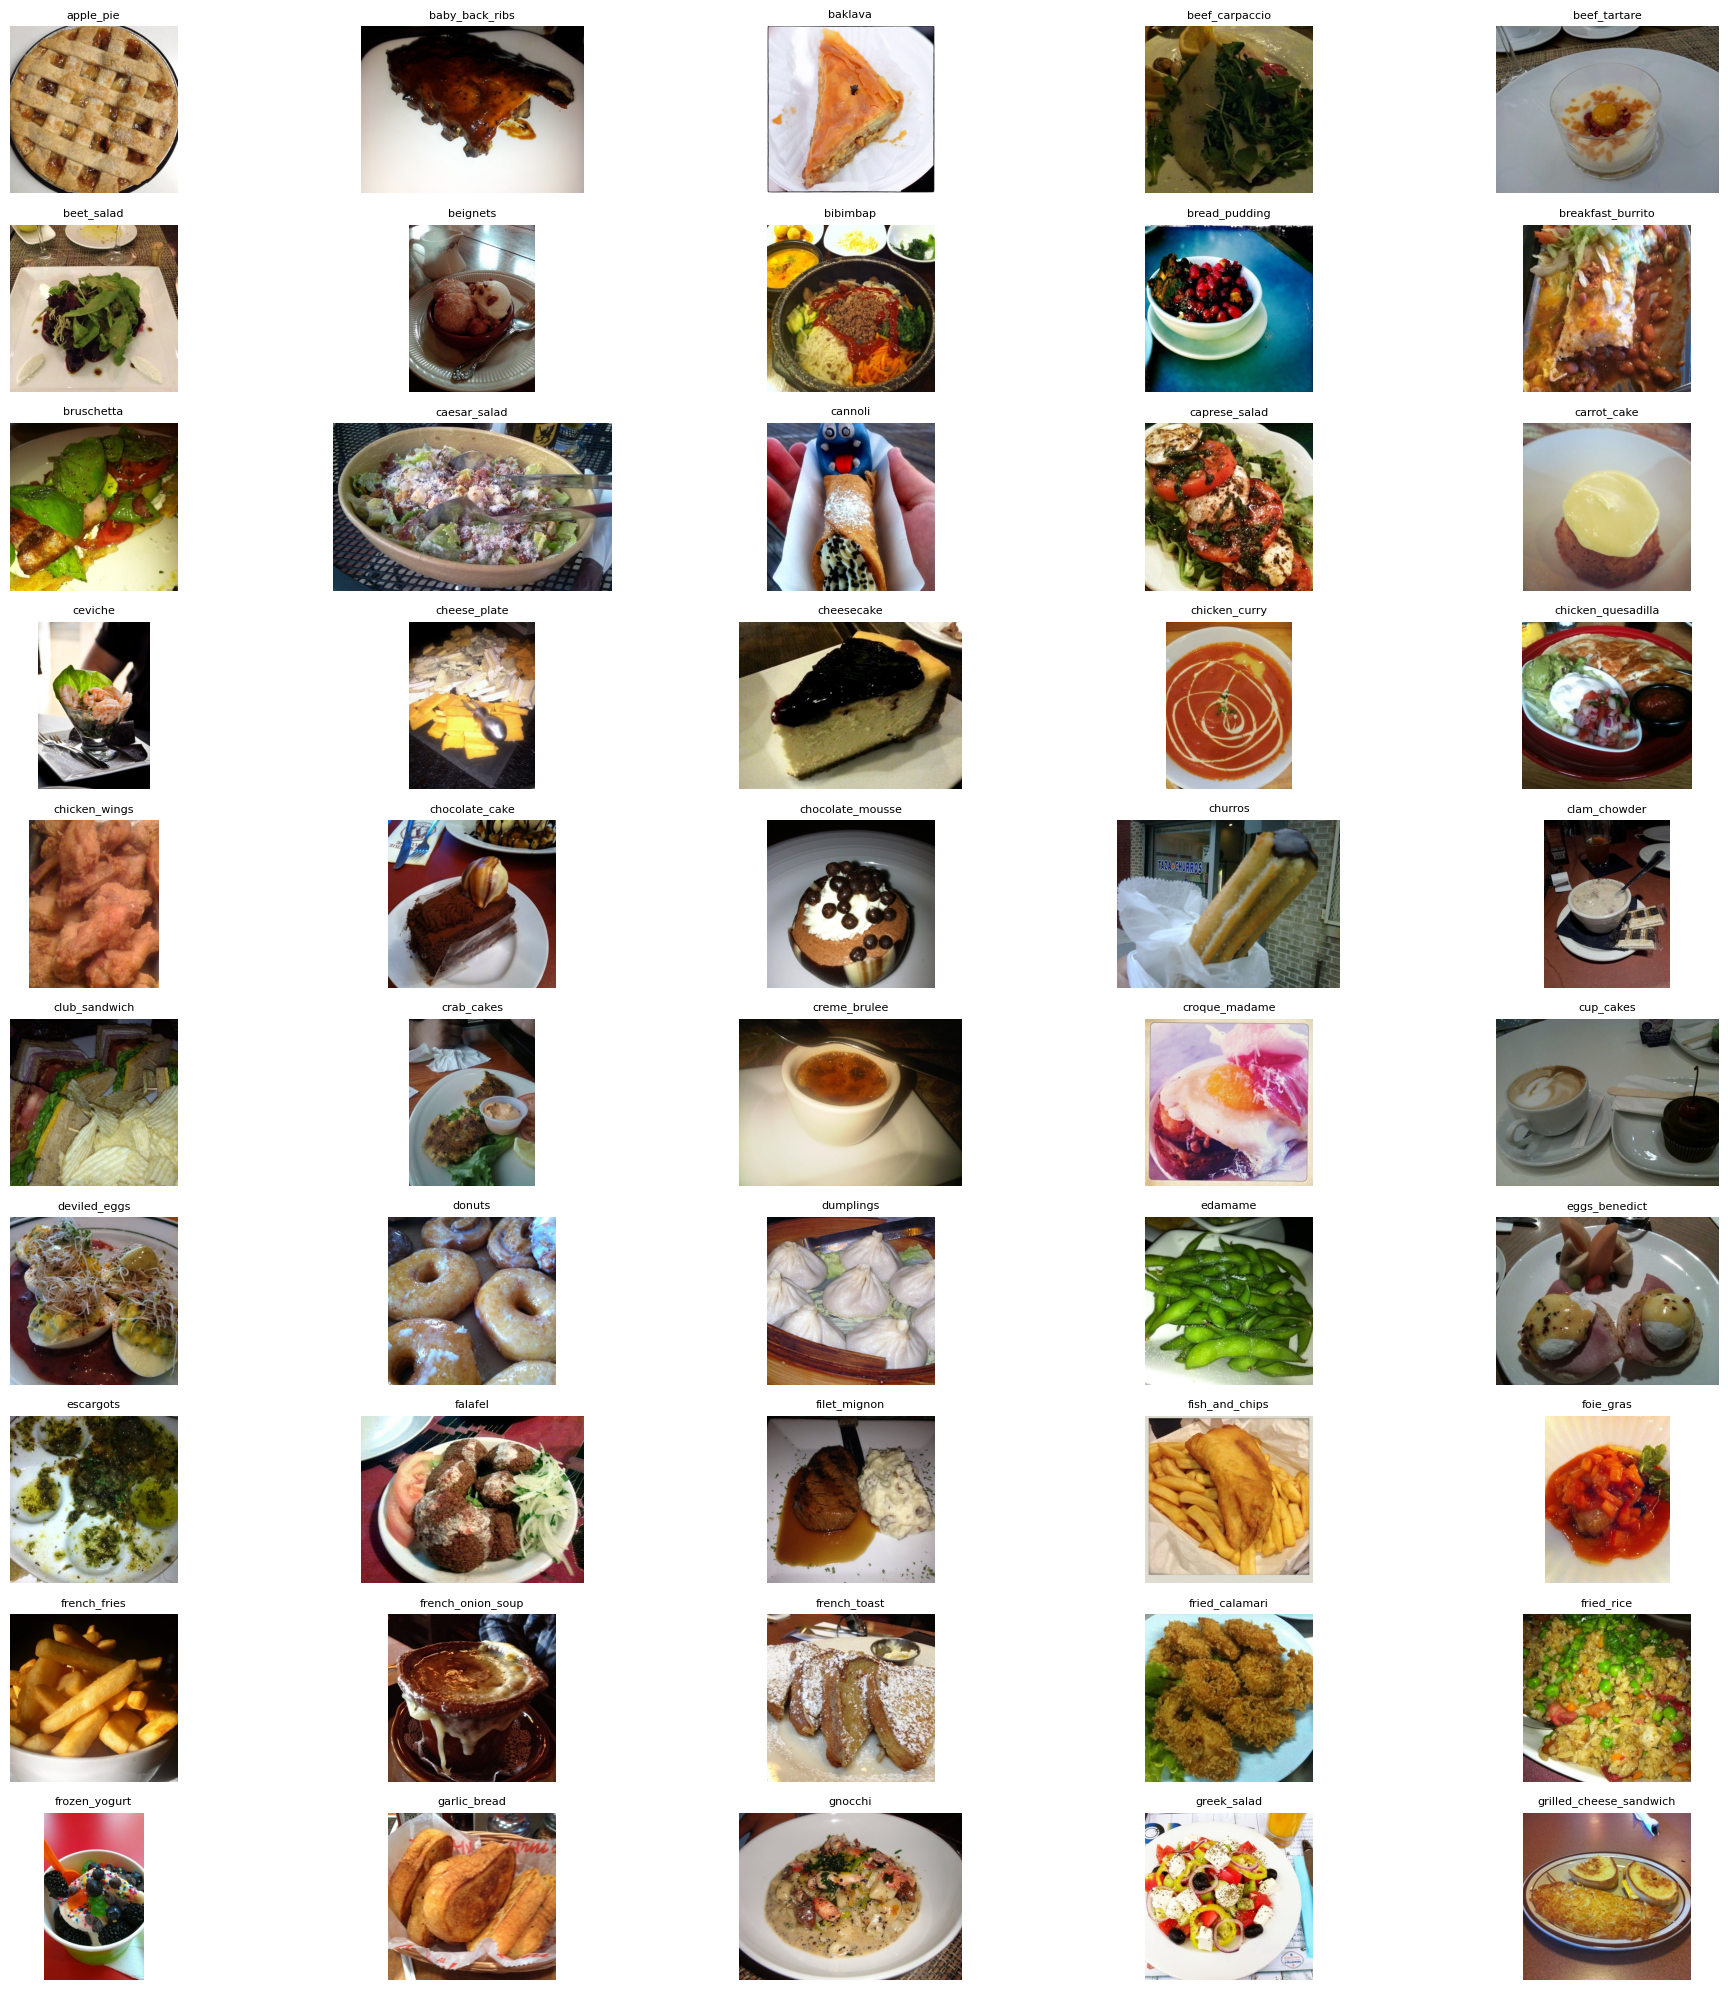

# Breast DC-GAN Training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from torch.nn.utils import spectral_norm

# Create output directories
os.makedirs('grid_samples', exist_ok=True)
os.makedirs('all_samples', exist_ok=True)
os.makedirs('loss_plots', exist_ok=True)

class MammographyDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(data_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.image_files[idx])
        image = Image.open(img_path).convert('L')
        
        if self.transform:
            image = self.transform(image)
            
        return image

class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        
        self.main = nn.Sequential(
            # Initial projection and reshape
            nn.Linear(latent_dim, 512 * 4 * 4),
            nn.BatchNorm1d(512 * 4 * 4),
            nn.ReLU(True),
            
            # Reshape
            nn.Unflatten(1, (512, 4, 4)),
            
            # 4x4 -> 8x8
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Dropout2d(0.2),
            
            # 8x8 -> 16x16
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Dropout2d(0.2),
            
            # 16x16 -> 32x32
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Dropout2d(0.1),
            
            # 32x32 -> 64x64
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
            # 64x64 -> 32x32
            nn.Conv2d(1, 64, 4, 2, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),
            
            # 32x32 -> 16x16
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),
            
            # 16x16 -> 8x8
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),
            
            # 8x8 -> 4x4
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),
            
            # 4x4 -> 1x1
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def plot_losses(g_losses, d_losses, epoch):
    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(d_losses, label='Discriminator Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title(f'GAN Losses up to Epoch {epoch+1}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'loss_plots/losses_epoch_{epoch+1}.png')
    plt.close()

def train_dcgan(dataloader, num_epochs, latent_dim, device):
    # Models
    generator = Generator(latent_dim).to(device)
    discriminator = Discriminator().to(device)
    
    # Initialize weights
    generator.apply(weights_init)
    discriminator.apply(weights_init)
    
    # Optimizers
    g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    
    criterion = nn.BCELoss()
    
    # Lists to store losses
    g_losses = []
    d_losses = []
    
    fixed_noise = torch.randn(50, latent_dim).to(device)  # For grid visualization
    
    for epoch in range(num_epochs):
        for i, real_images in enumerate(dataloader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)
            
            # Train Discriminator
            discriminator.zero_grad()
            label_real = torch.ones(batch_size).to(device)
            label_fake = torch.zeros(batch_size).to(device)
            
            output_real = discriminator(real_images)
            d_loss_real = criterion(output_real, label_real)
            
            noise = torch.randn(batch_size, latent_dim).to(device)
            fake_images = generator(noise)
            output_fake = discriminator(fake_images.detach())
            d_loss_fake = criterion(output_fake, label_fake)
            
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            d_optimizer.step()
            
            # Train Generator
            generator.zero_grad()
            output_fake = discriminator(fake_images)
            g_loss = criterion(output_fake, label_real)
            g_loss.backward()
            g_optimizer.step()
            
            # Store losses
            g_losses.append(g_loss.item())
            d_losses.append(d_loss.item())
            
            if i % 100 == 0:
                print(f'Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(dataloader)}] '
                      f'd_loss: {d_loss.item():.4f} g_loss: {g_loss.item():.4f}')
        
        # Generate and save grid samples
        with torch.no_grad():
            fake_grid = generator(fixed_noise)
            torchvision.utils.save_image(fake_grid, f'grid_samples/grid_epoch_{epoch+1}.png',
                                       normalize=True, nrow=10)
        
        # Generate and save all samples
        with torch.no_grad():
            all_samples = generator(torch.randn(100, latent_dim).to(device))
            for j, sample in enumerate(all_samples):
                torchvision.utils.save_image(sample, f'all_samples/sample_epoch_{epoch+1}_{j+1}.png',
                                           normalize=True)
        
        # Plot and save losses
        plot_losses(g_losses, d_losses, epoch)

def main():
    # Hyperparameters
    latent_dim = 100
    image_size = 64
    batch_size = 32
    num_epochs = 200
    
    # Data transforms
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    # Dataset and DataLoader
    dataset = MammographyDataset(
        data_dir='/kaggle/working/test_data',
        transform=transform
    )
    
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')
    
    try:
        train_dcgan(dataloader, num_epochs, latent_dim, device)
    except Exception as e:
        print(f'An error occurred: {str(e)}')
    finally:
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

if __name__ == '__main__':
    main()

# Original Breast Images 

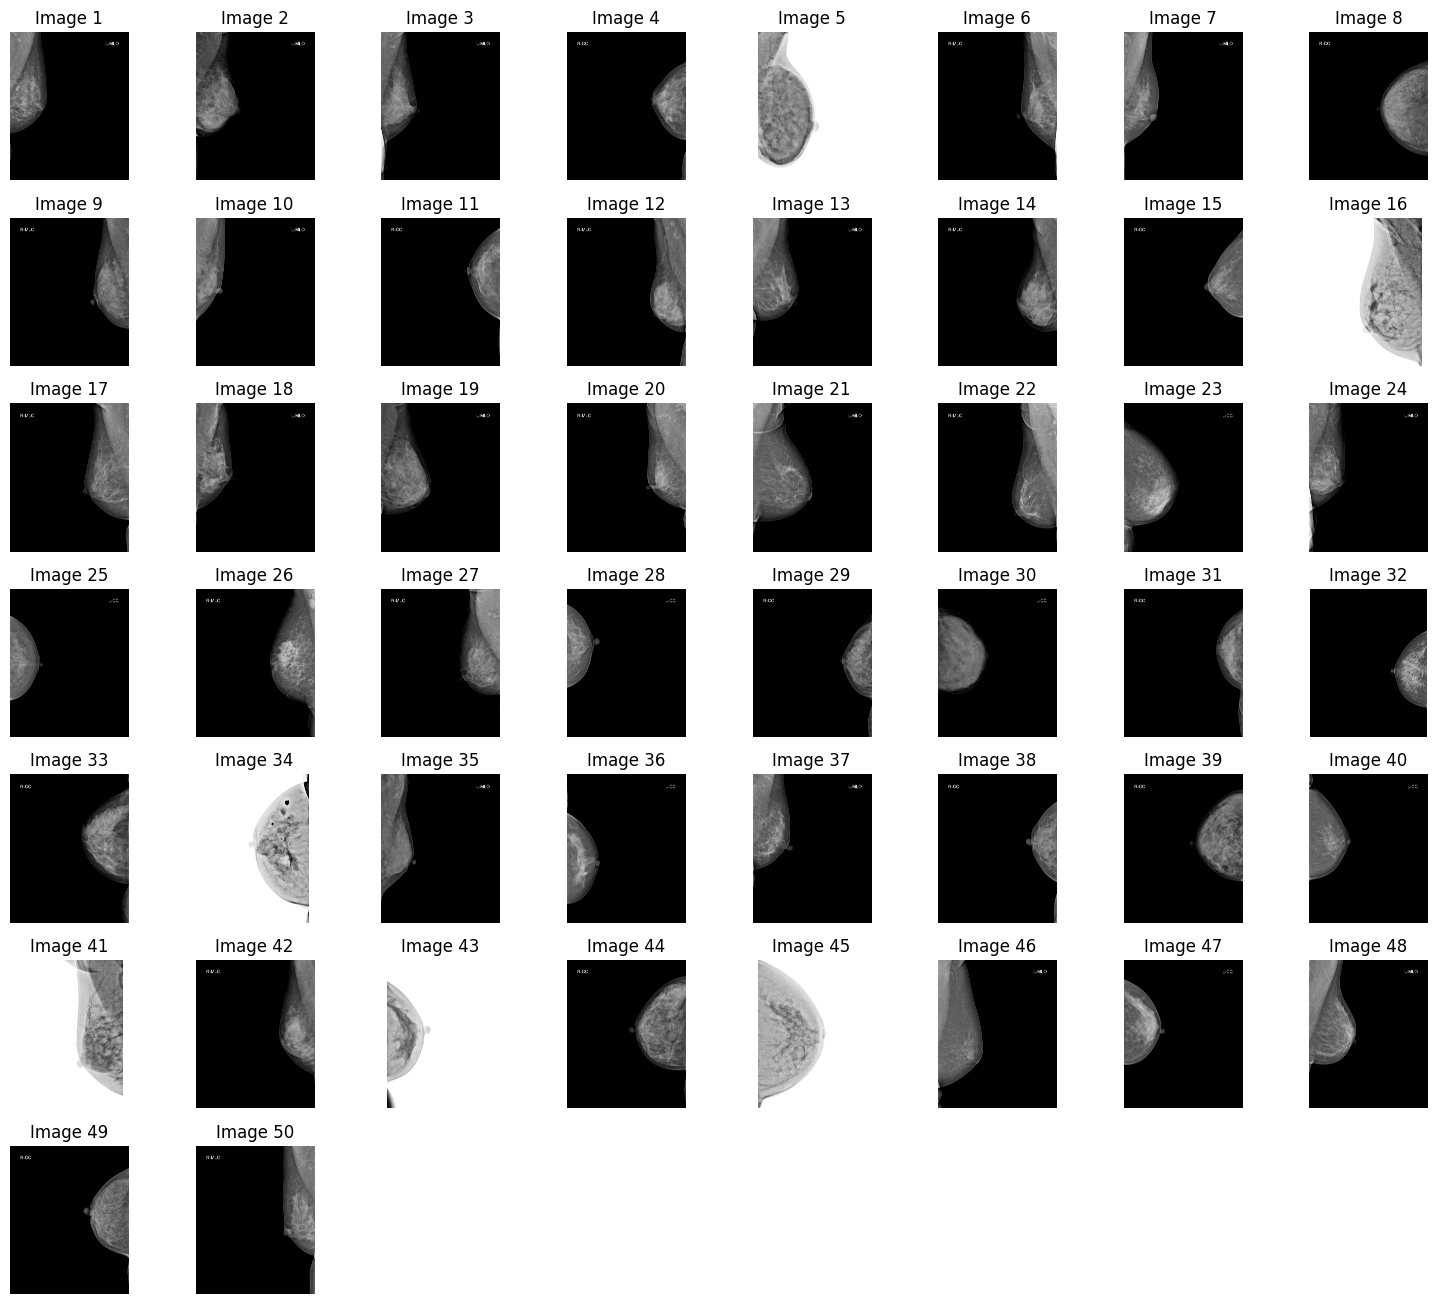

# Conclusion:

Three different training experiments were conducted with DCGAN using food, breast, and clothes datasets, each tested with various parameters. RGB food images produced results closer to reality, while breast images did not yield optimal results due to the presence of different classes within the dataset. Grayscale clothes images produced good results, suggesting that DCGAN can be effectively used for synthetic data generation in similar contexts.

# Sonuç:

(DCGAN ile yemek, meme (breast) ve kıyafet veri setleri kullanılarak üç farklı eğitim gerçekleştirildi ve çeşitli parametrelerle testler yapıldı. RGB formatındaki yemek görüntüleri gerçeğe daha yakın sonuçlar üretirken, veri seti içinde farklı sınıflar bulunması nedeniyle meme görüntüleri optimal sonuçlar vermedi. Gri tonlamalı kıyafet görüntüleri iyi sonuçlar üretti, bu da DCGAN'ın benzer bağlamlarda sentetik veri üretimi için etkili bir şekilde kullanılabileceğini göstermektedir.)